In [37]:
import numpy as np
import argparse
import time
import cv2
import os
import matplotlib.pyplot as plt
import os
%matplotlib.pyplot as plt

UsageError: Line magic function `%matplotlib.pyplot` not found.


In [38]:
CONFIDENCE = 0.5
SCORE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5

# the neural network configuration
config_path = "/media/sagar/HDD1/IIIT_PGSSP/CV/Project/MY_OBJ_DETECTION_Y/object-detection-opencv-master/yolov3.cfg"
# the YOLO net weights file
weights_path = "/media/sagar/HDD1/IIIT_PGSSP/CV/Project/MY_OBJ_DETECTION_Y/object-detection-opencv-master/yolov3.weights"
# weights_path = "weights/yolov3-tiny.weights"

# loading all the class labels (objects)
labels = open("/media/sagar/HDD1/IIIT_PGSSP/CV/Project/MY_OBJ_DETECTION_Y/object-detection-opencv-master/darknet/data/coco.names").read().strip().split("\n")
# generating colors for each object for later plotting
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

In [39]:
# load the YOLO network
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

In [40]:
path_name = "/media/sagar/HDD1/IIIT_PGSSP/CV/Project/MY_OBJ_DETECTION_Y/object-detection-opencv-master/img_5001.png"
image = cv2.imread(path_name)
file_name = os.path.basename(path_name)
filename, ext = file_name.split(".")

In [41]:
h, w = image.shape[:2]
# create 4D blob
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)

In [42]:
print("image.shape:", image.shape)
print("blob.shape:", blob.shape)

image.shape: (425, 560, 3)
blob.shape: (1, 3, 416, 416)


In [43]:
#output

In [44]:
image.shape: (1200, 1800, 3)
blob.shape: (1, 3, 416, 416)

In [20]:
# Making Predictions

In [21]:
# sets the blob as the input of the network
net.setInput(blob)
# get all the layer names
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
# feed forward (inference) and get the network output
# measure how much it took in seconds
start = time.perf_counter()
layer_outputs = net.forward(ln)
time_took = time.perf_counter() - start
print(f"Time took: {time_took:.2f}s")

Time took: 0.25s


In [22]:
font_scale = 1
thickness = 1
boxes, confidences, class_ids = [], [], []
# loop over each of the layer outputs
for output in layer_outputs:
    # loop over each of the object detections
    for detection in output:
        # extract the class id (label) and confidence (as a probability) of
        # the current object detection
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        # discard out weak predictions by ensuring the detected
        # probability is greater than the minimum probability
        if confidence > CONFIDENCE:
            # scale the bounding box coordinates back relative to the
            # size of the image, keeping in mind that YOLO actually
            # returns the center (x, y)-coordinates of the bounding
            # box followed by the boxes' width and height
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            # use the center (x, y)-coordinates to derive the top and
            # and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            # update our list of bounding box coordinates, confidences,
            # and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [23]:
print(detection.shape)

(85,)


In [24]:
boxes

[[137, 279, 145, 154], [414, 123, 81, 74], [145, 286, 126, 135]]

In [26]:
class_ids

[56, 68, 56]

In [27]:
#Draw

In [36]:
# loop over the indexes we are keeping
for i in range(len(boxes)):
    # extract the bounding box coordinates
    x, y = boxes[i][0], boxes[i][1]
    w, h = boxes[i][2], boxes[i][3]
#     print(x,y,w,h)
    # draw a bounding box rectangle and label on the image
    color = [int(c) for c in colors[class_ids[i]]]
    cv2.rectangle(image, (x, y), (x + w, y + h), color=color, thickness=thickness)
    text = f"{labels[class_ids[i]]}: {confidences[i]:.2f}"
    # calculate text width & height to draw the transparent boxes as background of the text
    (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, thickness=thickness)[0]
    text_offset_x = x
    text_offset_y = y - 5
    box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
    overlay = image.copy()
    cv2.rectangle(overlay, box_coords[0], box_coords[1], color=color, thickness=cv2.FILLED)
    # add opacity (transparency to the box)
    image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)
    # now put the text (label: confidence %)
    cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=font_scale, color=(0, 0, 0), thickness=thickness)

In [29]:
cv2.imwrite(filename + "_yolo3." + ext, image)

True

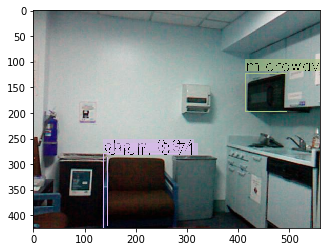

In [30]:
plt.imshow(image)

In [31]:
# IoU (Intersection over Union) is a technique used in Non-Maximal Suppression to compare how close two different bounding boxes are. It is simply demonstrated in the following figure

In [32]:
# perform the non maximum suppression given the scores defined before
idxs = cv2.dnn.NMSBoxes(boxes, confidences, SCORE_THRESHOLD, IOU_THRESHOLD)

In [33]:
# ensure at least one detection exists
if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
        # extract the bounding box coordinates
        x, y = boxes[i][0], boxes[i][1]
        w, h = boxes[i][2], boxes[i][3]
        # draw a bounding box rectangle and label on the image
        color = [int(c) for c in colors[class_ids[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color=color, thickness=thickness)
        text = f"{labels[class_ids[i]]}: {confidences[i]:.2f}"
        # calculate text width & height to draw the transparent boxes as background of the text
        (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, thickness=thickness)[0]
        text_offset_x = x
        text_offset_y = y - 5
        box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
        overlay = image.copy()
        cv2.rectangle(overlay, box_coords[0], box_coords[1], color=color, thickness=cv2.FILLED)
        # add opacity (transparency to the box)
        image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)
        # now put the text (label: confidence %)
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=font_scale, color=(0, 0, 0), thickness=thickness)

In [34]:
cv2.imwrite(filename + "_yolo3." + ext, image)

True